# 1. Install Dependencies and Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/My Drive/Python_Projects/ImageClassification-main')

In [6]:
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [10]:

import cv2
import imghdr

In [11]:
data_dir = 'data'

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

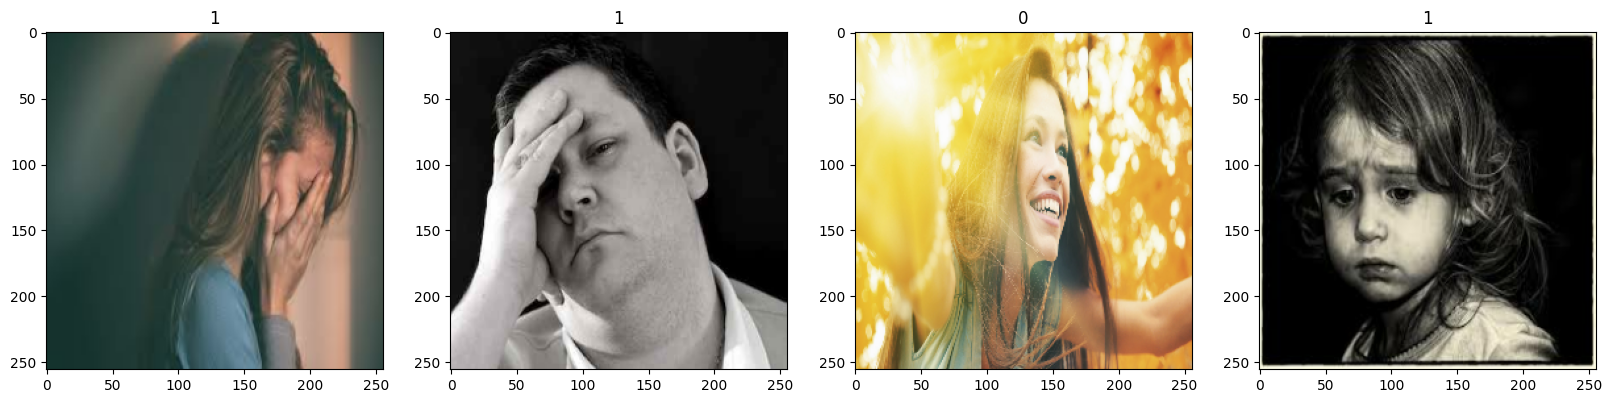

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next();

# 5. Split Data

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:

train_size


7

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [28]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [45]:
model = Sequential()

In [46]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 32)       

# 7. Train

In [49]:
logdir='logs'

In [50]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [51]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 16s 1s/step - loss: 0.6916 - accuracy: 0.5223 - val_loss: 0.6125 - val_accuracy: 0.7344
Epoch 2/20
7/7 [==============================] - 7s 636ms/step - loss: 0.6748 - accuracy: 0.6295 - val_loss: 0.6522 - val_accuracy: 0.7188
Epoch 3/20
7/7 [==============================] - 9s 970ms/step - loss: 0.6376 - accuracy: 0.7188 - val_loss: 0.6185 - val_accuracy: 0.7344
Epoch 4/20
7/7 [==============================] - 8s 940ms/step - loss: 0.5897 - accuracy: 0.7009 - val_loss: 0.4386 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 8s 939ms/step - loss: 0.5047 - accuracy: 0.7545 - val_loss: 0.5517 - val_accuracy: 0.6719
Epoch 6/20
7/7 [==============================] - 9s 680ms/step - loss: 0.4528 - accuracy: 0.8348 - val_loss: 0.3551 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 7s 721ms/step - loss: 0.3316 - accuracy: 0.8929 - val_loss: 0.3208 - val_accuracy: 0.8594
Epoch 8/20
7/7 [======

# 8. Plot Performance

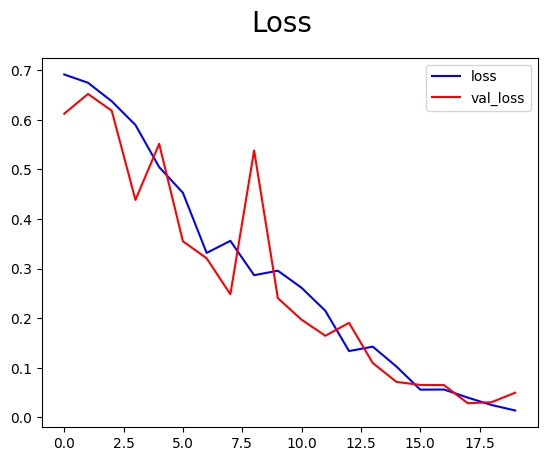

In [52]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

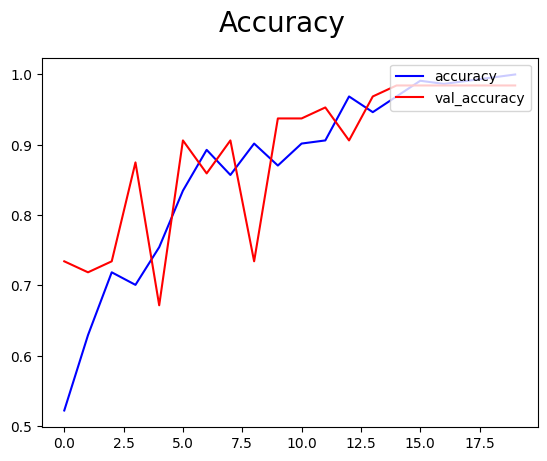

In [53]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper right")
plt.show()

# 9. Evaluate

In [54]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [55]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [56]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 496ms/step


In [57]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [58]:
import cv2

In [ ]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

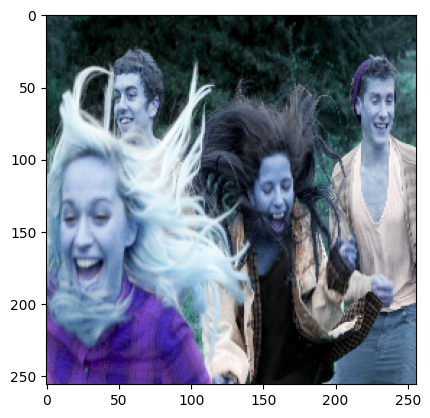

In [60]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 239ms/step


In [62]:
yhat

array([[0.06985468]], dtype=float32)

In [63]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [64]:
from tensorflow.keras.models import load_model

In [65]:
model.save(os.path.join('models','imageclassifier'))

In [69]:
new_model = load_model('models/imageclassifier')

In [70]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 79ms/step


array([[0.06985468]], dtype=float32)

# 12. Load the Model

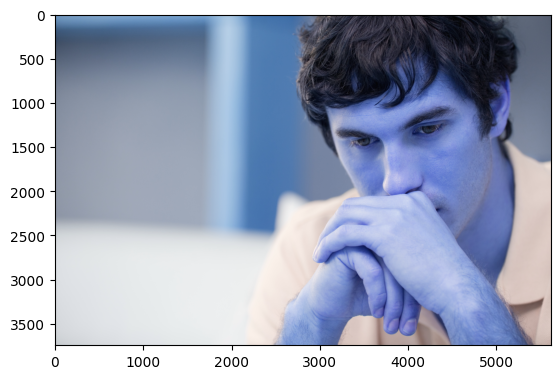

In [15]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('models/imageclassifier')

img = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()


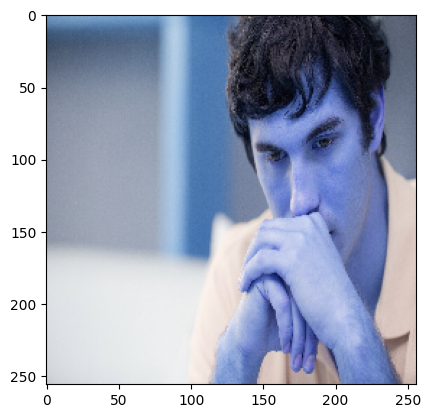

In [16]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [18]:

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

1/1 [==============================] - 0s 35ms/step
Predicted class is Sad
